# Production System Assignment

## Production System with PSP and RL agent optimization

In [1]:
from __future__ import annotations

import random
import statistics
from collections.abc import Callable, Sequence

import joblib.externals.cloudpickle
import numpy as np
import simpy
from scipy import stats
from simpy.events import ProcessGenerator
from lib.server import Server
from lib.job import Job
from matplotlib import pyplot as plt
from lib.config import SEEDS
import gymnasium as gym
from gymnasium import spaces
from stable_baselines3 import DQN
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.vec_env import VecNormalize
from stable_baselines3.common.running_mean_std import RunningMeanStd
import os

In [2]:
NUM_MACHINES = 6

In [3]:
MIN_THROUGHPUT_INTERVAL = 0.0
MAX_THROUGHPUT_INTERVAL = 1.0
MIN_TARDINESS_INTERVAL = 0.0
MAX_TARDINESS_INTERVAL = 1.0
MIN_EARLINESS_INTERVAL = 0.0
MAX_EARLINESS_INTERVAL = 1.0
MIN_WIP_WORK_CONTENT_INTERVAL = 0.0
MAX_WIP_WORK_CONTENT_INTERVAL = 1.0

In [4]:
class SystemEnv(gym.Env):
    def __init__(
        self,
        inter_arrival_time_distribution: Callable[[], float],
        processing_time_per_family_distribution: list[Callable[[], float]],
        families_distribution: Callable[[], float],
        due_dates_distribution: Callable[[], float],
        routing_distribution: dict[int, list[Callable[[], float]]],
        routing_prob: dict[int, list[float]],
        agent_decision_interval: float = 3.0, # 10, 5
        episode_duration: float = 60 * 160,
        reward_weights: dict[str, float] = None
    ) -> None:
        super().__init__()
        self.env: simpy.Environment | None = None
        self.inter_arrival_time_distribution = inter_arrival_time_distribution
        self.processing_time_per_family_distribution = processing_time_per_family_distribution
        self.families_distribution = families_distribution
        self.due_dates_distribution = due_dates_distribution
        self.routing_distribution = routing_distribution
        self.routing_prob = routing_prob
        self.agent_decision_interval = agent_decision_interval
        self.episode_duration = episode_duration

        self.e  = 0
        self.reward_weights = reward_weights if reward_weights is not None else {
            'throughput': 1.0,
            'wip_penalty': -1.0,
            'tardiness_penalty': -1.0,
            'earliness_penalty': -1.0
        }

        low_bounds = np.array([
            0.0,
            0.0,
            -5000.0,
            0.0,
            0.0,
            0.0,
            0.0,
            0.0,
            0.0,
            0.0
        ], dtype=np.float32)

        high_bounds = np.array([
            1.0,
            500.0,
            5000.0,
            1000.0,
            10000.0,
            10000.0,
            10000.0,
            10000.0,
            10000.0,
            10000.0
        ], dtype=np.float32)

        self.observation_space = spaces.Box(low=low_bounds, high=high_bounds, dtype=np.float32)

        # action space: 0 = Don't Release, 1 = Release
        self.action_space = spaces.Discrete(2)

        self.machines: list[Server] = []
        self.jobs: list[Job] = []
        self.pre_shop_pool: list[Job] = []
        self.idx_counter = 0

        self.jobs_completed_this_episode = 0
        self.total_tardiness_this_episode = 0.0
        self.total_earliness_this_episode = 0.0

        self.last_wip_value = 0.0
        self.last_wip_time = 0.0
        self.cumulative_wip_area = 0.0
        self.current_interval_wip_area = 0.0

        self.next_scheduled_arrival_time = float('inf')

        self.calibration_throughput_intervals: list[float] = []
        self.calibration_tardiness_intervals: list[float] = []
        self.calibration_earliness_intervals: list[float] = []
        self.calibration_avg_wip_intervals: list[float] = []

        self.calibration_obs_job_top_proc_time: list[float] = []
        self.calibration_obs_job_top_urgency: list[float] = []
        self.calibration_obs_raw_wip: list[float] = []
        self.calibration_obs_machine_workloads_flat: list[float] = []

    def compute_wip_for_servers(self) -> list[float]:
        servers_wip = [0.0] * 6
        for idx, server in enumerate(self.machines):
            server_wip = 0
            for job in [job for job in self.jobs if not job.done and job.in_system]:
                try:
                    if server in job.routing:
                        server_idx_for_current_job = job.routing.index(server)
                        if server_idx_for_current_job >= job.current_step_index:
                            server_wip += job.process_times[server_idx_for_current_job]

                            if job.current_step_index == server_idx_for_current_job and \
                                    job.current_process_start_time is not None and \
                                    server.job_on_machine == job:
                                time_spent_in_current_op = self.env.now - job.current_process_start_time
                                server_wip -= min(time_spent_in_current_op, job.process_times[server_idx_for_current_job])
                                server_wip = max(0.0, server_wip)

                except ValueError:
                    pass
            servers_wip[idx] = server_wip
        return servers_wip

    def _update_wip_area(self):
        now = self.env.now
        duration = now - self.last_wip_time
        if duration > 0:
            self.cumulative_wip_area += self.last_wip_value * duration
            self.current_interval_wip_area += self.last_wip_value * duration
        self.last_wip_time = now
        self.last_wip_value = sum(self.compute_wip_for_servers())

    def _set_seed(self, seed: int | None = None):
        if seed is not None:
            random.seed(seed)
            np.random.seed(seed)

    def reset(self, seed: int | None = None, options: dict | None = None) -> tuple[np.ndarray, dict]:
        super().reset(seed=seed)
        self._set_seed(seed)

        self.env = simpy.Environment()
        self.machines = [Server(self.env, 1, f"WC{i+1}") for i in range(6)]
        self.pre_shop_pool = []
        self.jobs = []

        self.idx_counter = 0

        self.jobs_completed_this_episode = 0
        self.total_tardiness_this_episode = 0.0
        self.total_earliness_this_episode = 0.0

        self.last_wip_value = 0
        self.last_wip_time = self.env.now
        self.cumulative_wip_area = 0.0
        self.current_interval_wip_area = 0.0

        self.next_scheduled_arrival_time = float('inf')

        self.env.process(self._run_job_arrivals())

        observation = self._get_obs()
        info = self._get_info()

        return observation, info

    def step(self, action: int) -> tuple[np.ndarray, float, bool, bool, dict]:
        jobs_completed_before_step = self.jobs_completed_this_episode
        tardiness_before_step = self.total_tardiness_this_episode
        earliness_before_step = self.total_earliness_this_episode

        self.current_interval_wip_area = 0.0
        self._update_wip_area()

        if action == 1:
            self._release_job_from_psp()
            self._update_wip_area()

        time_to_advance = self.agent_decision_interval
        if self.next_scheduled_arrival_time < self.env.now + self.agent_decision_interval:
            time_to_advance = self.next_scheduled_arrival_time - self.env.now

        time_to_advance = max(1e-9, time_to_advance) # to make sure that the simulation will proceed, even if for a very short time
        self.env.run(until=self.env.now + time_to_advance)

        self._update_wip_area()

        if self.env.now >= self.next_scheduled_arrival_time - 1e-9:
            self.next_scheduled_arrival_time = float('inf')

        avg_wip_for_reward_interval = self.current_interval_wip_area / time_to_advance if time_to_advance > 0 else 0.0

        jobs_completed_in_interval = self.jobs_completed_this_episode - jobs_completed_before_step
        tardiness_in_interval = self.total_tardiness_this_episode - tardiness_before_step
        earliness_in_interval = self.total_earliness_this_episode - earliness_before_step

        self.calibration_throughput_intervals.append(float(jobs_completed_in_interval))
        self.calibration_tardiness_intervals.append(tardiness_in_interval)
        self.calibration_earliness_intervals.append(earliness_in_interval)
        self.calibration_avg_wip_intervals.append(avg_wip_for_reward_interval)

        reward = self._calculate_reward(
            jobs_completed_in_interval,
            tardiness_in_interval,
            earliness_in_interval,
            avg_wip_for_reward_interval
        )

        terminated = self.env.now >= self.episode_duration
        if terminated:
            print(f"Episode {self.e} terminated")
            self.e += 1
        truncated = False

        observation = self._get_obs()
        self.calibration_obs_job_top_proc_time.append(observation[1])
        self.calibration_obs_job_top_urgency.append(observation[2])
        self.calibration_obs_raw_wip.append(observation[3])
        self.calibration_obs_machine_workloads_flat.extend(observation[4:])

        info = self._get_info()

        if terminated:
            self._update_wip_area()
            average_wip_for_episode = self.cumulative_wip_area / self.episode_duration if self.episode_duration > 0 else 0
            info["average_wip_for_episode"] = average_wip_for_episode
            info["total_simulation_time_minutes"] = self.env.now

        return observation, reward, terminated, truncated, info

    def _get_obs(self) -> np.ndarray:
        presence_job_top = 1.0 if self.pre_shop_pool else 0.0

        job_top_proc_time = 0.0
        job_top_urgency = 0.0
        if presence_job_top == 1.0:
            job_top = self.pre_shop_pool[0]
            job_top_proc_time = job_top.total_processing_time
            job_top_urgency = job_top.due_date - self.env.now

        raw_wip = self.last_wip_value # change, I don't like it

        machine_workloads = self.compute_wip_for_servers()

        return np.array([
            presence_job_top,
            job_top_proc_time,
            job_top_urgency,
            float(raw_wip),
            *machine_workloads
        ], dtype=np.float32)

    def _run_job_arrivals(self) -> ProcessGenerator:
        while True:
            timeout_inter_arrival = self.inter_arrival_time_distribution()
            self.next_scheduled_arrival_time = self.env.now + timeout_inter_arrival
            yield self.env.timeout(timeout_inter_arrival)

            weight = self.families_distribution()
            if weight <= 0.1:
                family = 1
            elif weight <= 0.62:
                family = 2
            else:
                family = 3

            due_date_offset = self.due_dates_distribution()

            family_routing_distr = self.routing_distribution[family]
            family_routing_prob = self.routing_prob[family]

            job_routing = []
            processing_times = []
            for i in range(6):
                if family_routing_distr[i]() <= family_routing_prob[i]:
                    job_routing.append(self.machines[i])
                    processing_times.append(self.processing_time_per_family_distribution[family-1]())

            job = Job(
                env=self.env,
                routing=job_routing,
                arrival_time=self.env.now,
                process_times=processing_times,
                due_date=(self.env.now + due_date_offset),
                idx=self.idx_counter,
                family="F{}".format(family),
                completion_callback=self._job_completed_callback
            )

            self.idx_counter += 1
            self.jobs.append(job)
            self.pre_shop_pool.append(job)

    def _release_job_from_psp(self):
        if self.pre_shop_pool:
            job_to_release = self.pre_shop_pool.pop(0)

            job_to_release.in_system = True
            self.env.process(job_to_release.main())


    def _job_completed_callback(self, job: Job):
        job.in_system = False
        self.jobs_completed_this_episode += 1
        self.total_tardiness_this_episode += job.tardiness
        self.total_earliness_this_episode += job.earliness


    def _calculate_reward(self, jobs_completed_in_interval: int, tardiness_in_interval: float, earliness_in_interval: float, avg_wip_for_reward_interval: int) -> float:

        scaled_throughput = (jobs_completed_in_interval - MIN_THROUGHPUT_INTERVAL) / \
                            (MAX_THROUGHPUT_INTERVAL - MIN_THROUGHPUT_INTERVAL + 1e-8)
        scaled_tardiness = (tardiness_in_interval - MIN_TARDINESS_INTERVAL) / \
                           (MAX_TARDINESS_INTERVAL - MIN_TARDINESS_INTERVAL + 1e-8)
        scaled_earliness = (earliness_in_interval - MIN_EARLINESS_INTERVAL) / \
                           (MAX_EARLINESS_INTERVAL - MIN_EARLINESS_INTERVAL + 1e-8)
        scaled_wip = (avg_wip_for_reward_interval - MIN_WIP_WORK_CONTENT_INTERVAL) / \
                     (MAX_WIP_WORK_CONTENT_INTERVAL - MIN_WIP_WORK_CONTENT_INTERVAL + 1e-8)

        reward = (self.reward_weights['throughput'] * scaled_throughput) + \
                 (self.reward_weights['tardiness_penalty'] * scaled_tardiness) + \
                 (self.reward_weights['earliness_penalty'] * scaled_earliness) + \
                 (self.reward_weights['wip_penalty'] * scaled_wip)
        return reward

    def _get_info(self) -> dict:
        info = {
            "current_time": self.env.now,
            "jobs_in_psp": len(self.pre_shop_pool),
            "mean_wip": self.cumulative_wip_area / self.env.now if self.env.now != 0.0 else 0.0,
            "jobs_completed_episode": self.jobs_completed_this_episode,
            "total_tardiness_episode": self.total_tardiness_this_episode,
            "total_earliness_episode": self.total_earliness_this_episode
        }
        return info


## Throwaway Agent Training to find scaling factors

In [11]:
N_THROW_AWAY_EPISODES = 20
THROW_AWAY_EPISODE_DURATION = 60 * 160
THROW_AWAY_AGENT_DECISION_INTERVAL = 1.5
TOTAL_TIMESTEPS_FOR_THROWAWAY_TRAINING = int(N_THROW_AWAY_EPISODES * (THROW_AWAY_EPISODE_DURATION / THROW_AWAY_AGENT_DECISION_INTERVAL))
print(TOTAL_TIMESTEPS_FOR_THROWAWAY_TRAINING)

128000


Starting calibration training for 20 episodes.
Total duration of an episode: 160 hours.
Max decision interval of the agent (It will choose each time a job arrives): 1.5 minutes.
Total Timesteps: 128000.
Using cpu device
Episode 0 terminated
Episode 1 terminated
Episode 2 terminated
Episode 3 terminated
Episode 4 terminated
Episode 5 terminated
Episode 6 terminated
Episode 7 terminated
Episode 8 terminated
Episode 9 terminated
-----------------------------------
| rollout/            |           |
|    ep_len_mean      | 4.58e+03  |
|    ep_rew_mean      | -1.43e+06 |
|    exploration_rate | 0.05      |
| time/               |           |
|    episodes         | 10        |
|    fps              | 228       |
|    time_elapsed     | 200       |
|    total_timesteps  | 45793     |
| train/              |           |
|    learning_rate    | 0.0001    |
|    loss             | 205       |
|    n_updates        | 44792     |
-----------------------------------
Episode 10 terminated
Episode 

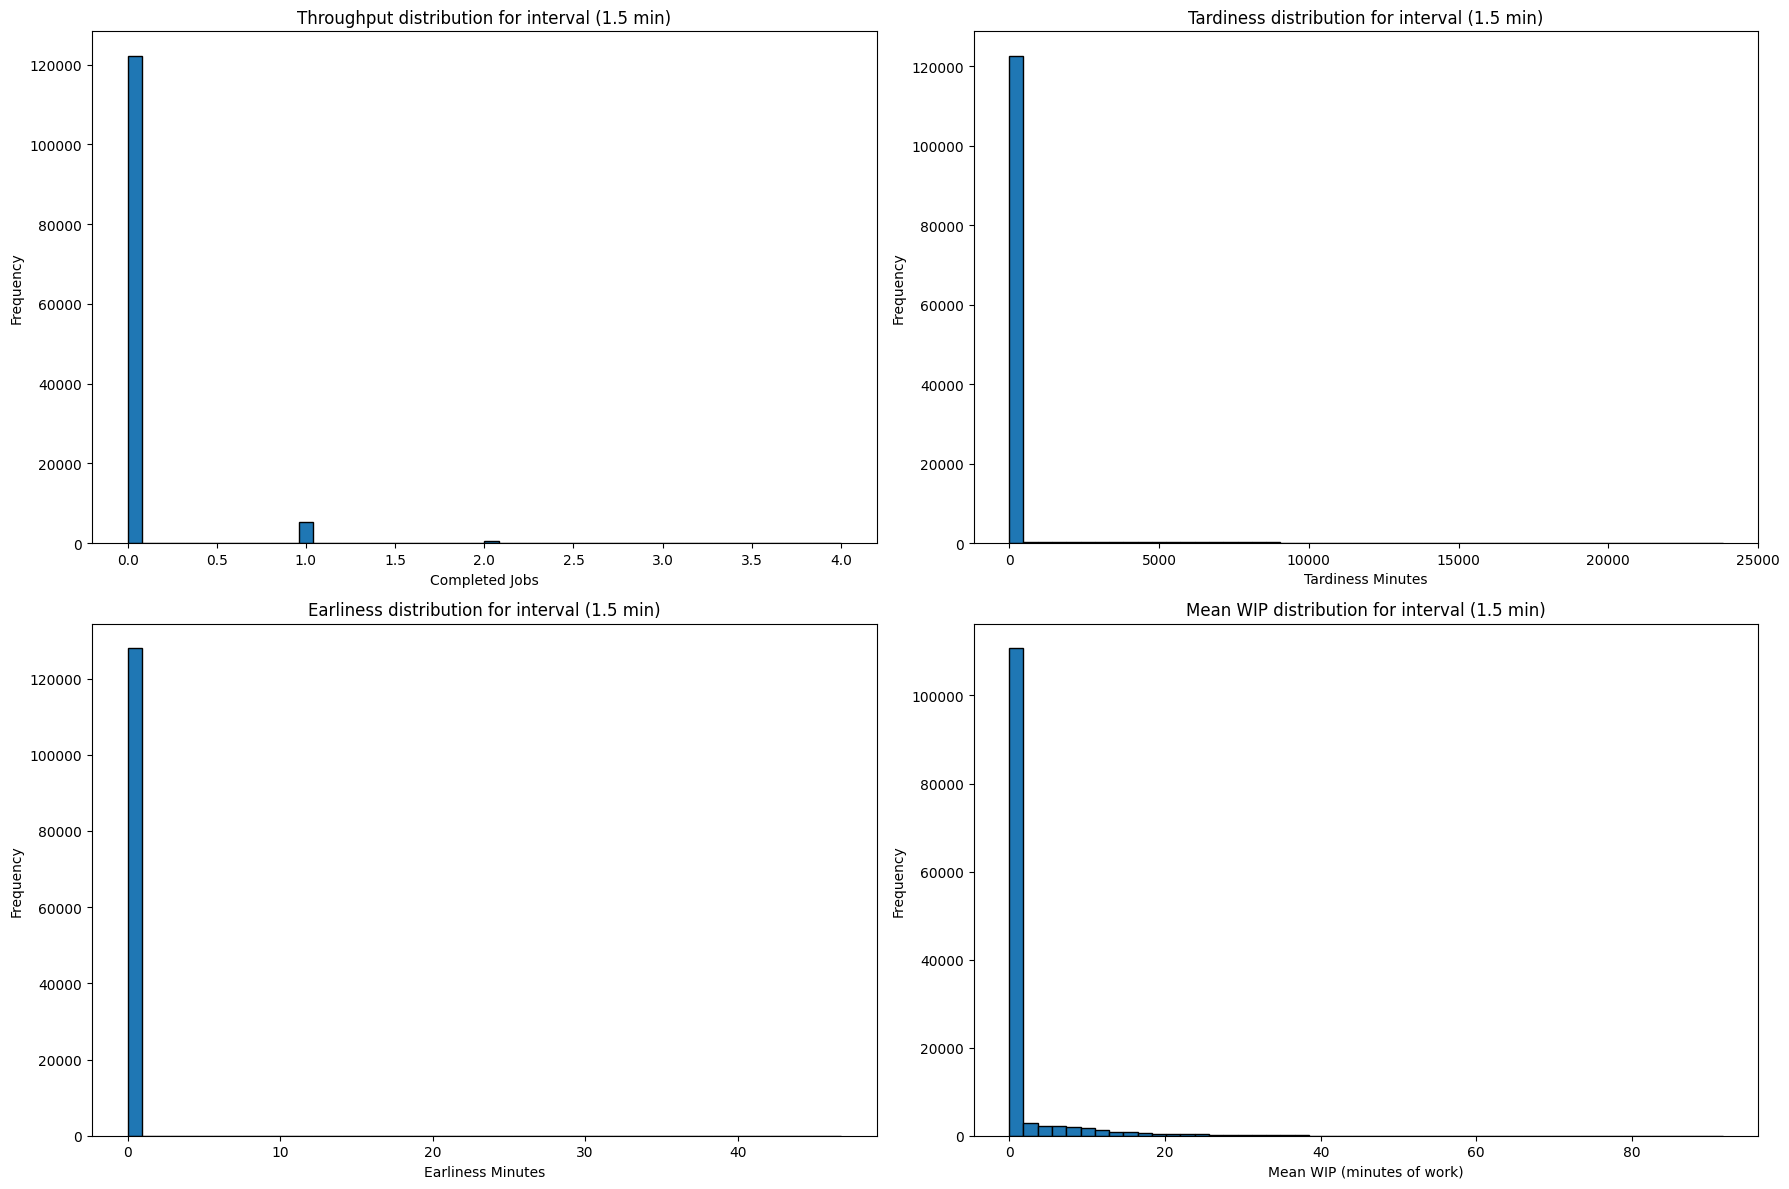

Obs - Job Top Proc Time: Min=0.55, Max=29.93
Obs - Job Top Urgency: Min=-9268.18, Max=-51.15
Obs - WIP Work Content (raw): Min=0.00, Max=21.21


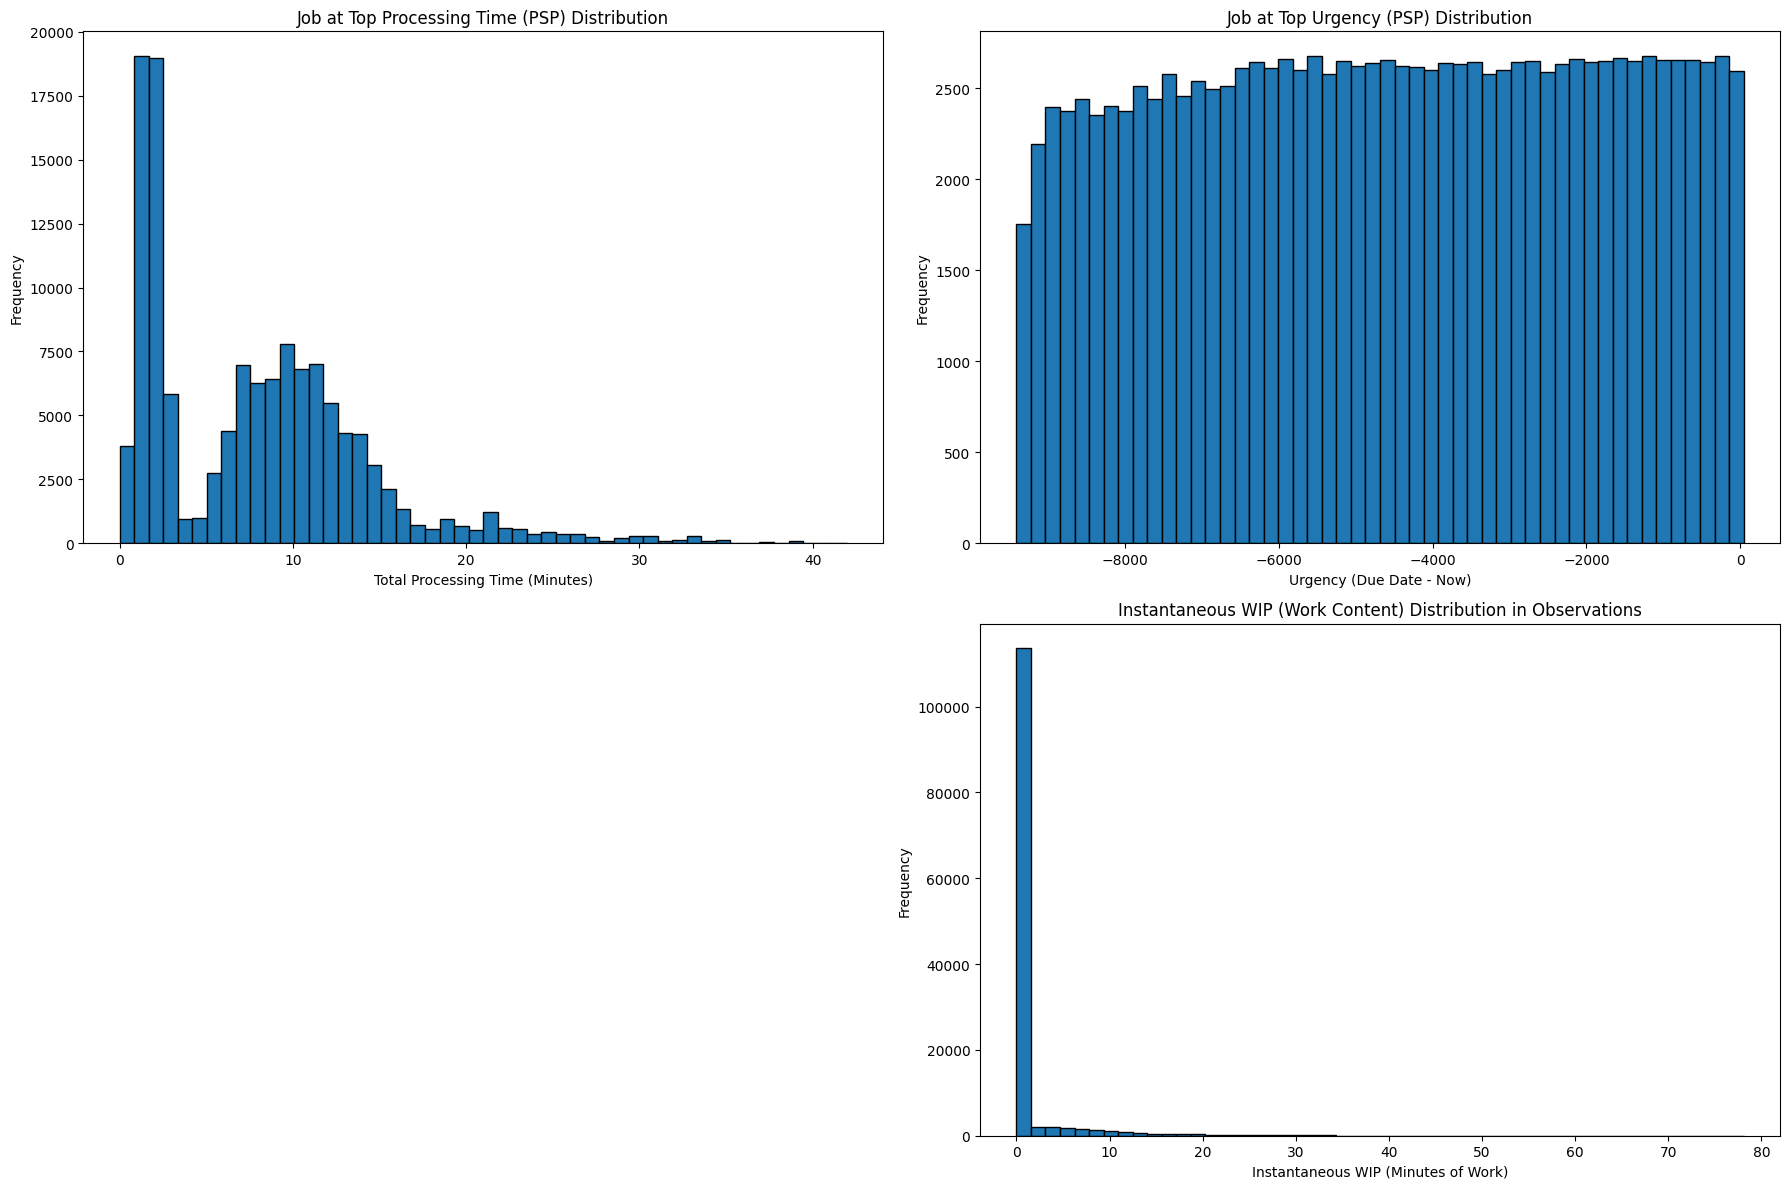

Obs - Machine Workloads (flattened): Min=0.00, Max=4.71


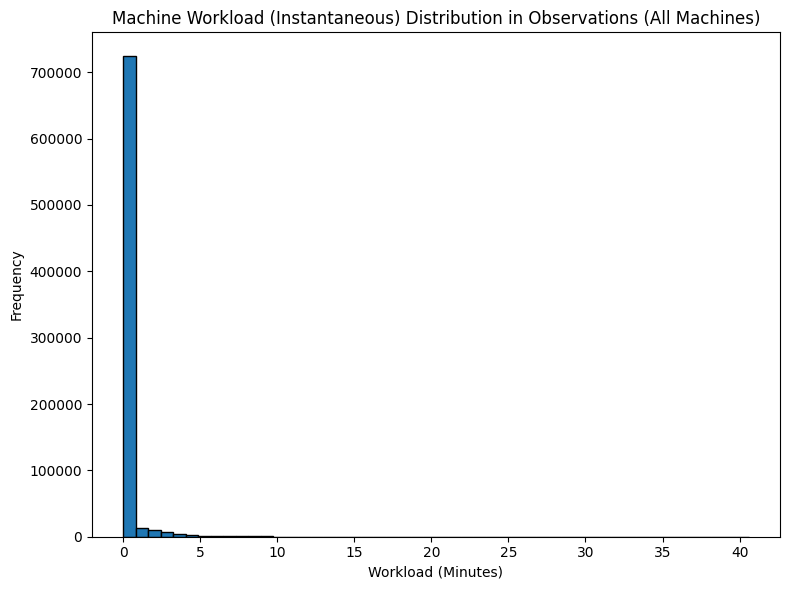


--- Summary of Calibrated Values to Insert into SystemEnv.py (for RL training) ---
# --- REWARD SCALING PARAMETERS ---
MIN_THROUGHPUT_INTERVAL = 0.00
MAX_THROUGHPUT_INTERVAL = 1.00
MIN_TARDINESS_INTERVAL = 0.00
MAX_TARDINESS_INTERVAL = 6516.59
MIN_EARLINESS_INTERVAL = 0.00
MAX_EARLINESS_INTERVAL = 0.00
MIN_WIP_WORK_CONTENT_INTERVAL = 0.00
MAX_WIP_WORK_CONTENT_INTERVAL = 25.10

# --- OBSERVATION SPACE BOUNDS ---
low_bounds = np.array([
    0.55, # job_top_proc_time
    -9268.18, # job_top_urgency
    0.00, # raw_wip
    0.00, # machine_workload WC1
    0.00, # machine_workload WC2
    0.00, # machine_workload WC3
    0.00, # machine_workload WC4
    0.00, # machine_workload WC5
    0.00, # machine_workload WC6
], dtype=np.float32)

high_bounds = np.array([
    29.93, # job_top_proc_time
    -51.15, # job_top_urgency
    21.21, # raw_wip
    4.71, # machine_workload WC1
    4.71, # machine_workload WC2
    4.71, # machine_workload WC3
    4.71, # machine_workload WC4
    4.71, # machine

In [12]:
print(f"Starting calibration training for {N_THROW_AWAY_EPISODES} episodes.")
print(f"Total duration of an episode: {THROW_AWAY_EPISODE_DURATION/60:.0f} hours.")
print(f"Max decision interval of the agent (It will choose each time a job arrives): {THROW_AWAY_AGENT_DECISION_INTERVAL} minutes.")
print(f"Total Timesteps: {TOTAL_TIMESTEPS_FOR_THROWAWAY_TRAINING}.")

def make_env():
    return SystemEnv(
        inter_arrival_time_distribution=lambda: random.expovariate(lambd=0.65),
        processing_time_per_family_distribution=[
            lambda: random.gammavariate(2,2),
            lambda: random.gammavariate(4,0.5),
            lambda: random.gammavariate(6,1/6)
        ],
        families_distribution=lambda: random.random(),
        routing_distribution={
            1: [lambda: random.random(), lambda: random.random(), lambda: random.random(),lambda: random.random(),lambda: random.random(),lambda: random.random()],
            2: [lambda: random.random(), lambda: random.random(), lambda: random.random(),lambda: random.random(),lambda: random.random(),lambda: random.random()],
            3: [lambda: random.random(), lambda: random.random(), lambda: random.random(),lambda: random.random(),lambda: random.random(),lambda: random.random()]
        },
        routing_prob={
            1: [1,1,0,1,1,1],
            2: [0.8, 0.8, 1, 0.8, 0.8, 0.75],
            3: [0,0,1,0,0,0.75]
        },
        due_dates_distribution=lambda: random.uniform(30,50),
        reward_weights={
            'throughput': 1.0,
            'wip_penalty': -1,
            'earliness_penalty': -1,
            'tardiness_penalty': -1
        }
    )

seed = 42
vec_env = make_vec_env(make_env, n_envs=1, seed=42)
model = DQN(
    "MlpPolicy",
    vec_env,
    verbose=1,
    learning_rate=1e-4,
    buffer_size=50000,
    learning_starts=1000,
    batch_size=32,
    tau=1.0,
    gamma=0.99,
    train_freq=(1, "step"),
    gradient_steps=1,
    exploration_fraction=0.1,
    exploration_initial_eps=1.0,
    exploration_final_eps=0.05,
    target_update_interval=1000,
    seed=seed
)
model.learn(total_timesteps=TOTAL_TIMESTEPS_FOR_THROWAWAY_TRAINING, log_interval=10)

print("\n--- Starting Calibration Analysis ---")

calib_env = vec_env.envs[0].env

def get_min_max_percentile(data: list[float], low_p: float=1, high_p: float=99, clip_min_to_zero: bool = True):
    if not data:
        print(f"Given list is empty.")
        return 0.0, 1.0

    data_np = np.array(data)
    data_np = data_np[np.isfinite(data_np)]
    if data_np.size == 0:
        print(f"Attention: no more values are left after filtering the infinite values")
        return 0.0, 1.0

    min_val = np.percentile(data_np, low_p)
    max_val = np.percentile(data_np, high_p)
    if clip_min_to_zero:
        return float(max(0.0, min_val)), float(max_val)
    return float(min_val), float(max_val)


plt.figure(figsize=(18, 12))

plt.subplot(2, 2, 1)
if calib_env.calibration_throughput_intervals:
    plt.hist(calib_env.calibration_throughput_intervals, bins=50, edgecolor='black')
    min_th, max_th = get_min_max_percentile(calib_env.calibration_throughput_intervals)
    plt.title(f'Throughput distribution for interval ({THROW_AWAY_AGENT_DECISION_INTERVAL} min)')
    plt.xlabel('Completed Jobs')
    plt.ylabel('Frequency')
    print(f"Reward - Throughput Interval: Min={min_th:.2f}, Max={max_th:.2f}")
else:
    print("No throughput data left")
    min_th, max_th = 0.0, 1.0

plt.subplot(2, 2, 2)
if calib_env.calibration_tardiness_intervals:
    plt.hist(calib_env.calibration_tardiness_intervals, bins=50, edgecolor='black')
    min_tardiness, max_tardiness = get_min_max_percentile(calib_env.calibration_tardiness_intervals)
    plt.title(f'Tardiness distribution for interval ({THROW_AWAY_AGENT_DECISION_INTERVAL} min)')
    plt.xlabel('Tardiness Minutes')
    plt.ylabel('Frequency')
    print(f"Reward - Tardiness Interval: Min={min_tardiness:.2f}, Max={max_tardiness:.2f}")
else:
    print("No tardiness data left")
    min_tardiness, max_tardiness = 0.0, 1.0

plt.subplot(2, 2, 3)
if calib_env.calibration_earliness_intervals:
    plt.hist(calib_env.calibration_earliness_intervals, bins=50, edgecolor='black')
    min_earliness, max_earliness = get_min_max_percentile(calib_env.calibration_earliness_intervals)
    plt.title(f'Earliness distribution for interval ({THROW_AWAY_AGENT_DECISION_INTERVAL} min)')
    plt.xlabel('Earliness Minutes')
    plt.ylabel('Frequency')
    print(f"Reward - Earliness Interval: Min={min_earliness:.2f}, Max={max_earliness:.2f}")
else:
    print("No earliness data left")
    min_earliness, max_earliness = 0.0, 1.0


plt.subplot(2, 2, 4)
if calib_env.calibration_avg_wip_intervals:
    plt.hist(calib_env.calibration_avg_wip_intervals, bins=50, edgecolor='black')
    min_wip_wc_reward, max_wip_wc_reward = get_min_max_percentile(calib_env.calibration_avg_wip_intervals)
    plt.title(f'Mean WIP distribution for interval ({THROW_AWAY_AGENT_DECISION_INTERVAL} min)')
    plt.xlabel('Mean WIP (minutes of work)')
    plt.ylabel('Frequency')
    print(f"Reward - WIP Interval: Min={min_wip_wc_reward:.2f}, Max={max_wip_wc_reward:.2f}")
else:
    print("No WIP data left")
    min_wip_wc_reward, max_wip_wc_reward = 0.0, 1.0 # Default se non ci sono dati

plt.tight_layout()
plt.show()

plt.figure(figsize=(18, 12))

plt.subplot(2, 2, 1)
if calib_env.calibration_obs_job_top_proc_time:
    plt.hist(calib_env.calibration_obs_job_top_proc_time, bins=50, edgecolor='black')
    min_jtpt, max_jtpt = get_min_max_percentile(calib_env.calibration_obs_job_top_proc_time)
    plt.title('Job at Top Processing Time (PSP) Distribution')
    plt.xlabel('Total Processing Time (Minutes)')
    plt.ylabel('Frequency')
    print(f"Obs - Job Top Proc Time: Min={min_jtpt:.2f}, Max={max_jtpt:.2f}")
else:
    print("No job top processing time data collected for plotting.")
    min_jtpt, max_jtpt = 0.0, 1.0


plt.subplot(2, 2, 2)
if calib_env.calibration_obs_job_top_urgency:
    plt.hist(calib_env.calibration_obs_job_top_urgency, bins=50, edgecolor='black')
    min_jtu, max_jtu = get_min_max_percentile(calib_env.calibration_obs_job_top_urgency, clip_min_to_zero=False)
    plt.title('Job at Top Urgency (PSP) Distribution')
    plt.xlabel('Urgency (Due Date - Now)')
    plt.ylabel('Frequency')
    print(f"Obs - Job Top Urgency: Min={min_jtu:.2f}, Max={max_jtu:.2f}")
else:
    print("No job top urgency data collected for plotting.")
    min_jtu, max_jtu = -100.0, 100.0

plt.subplot(2, 2, 4)
if calib_env.calibration_obs_raw_wip:
    plt.hist(calib_env.calibration_obs_raw_wip, bins=50, edgecolor='black')
    min_wip_wc_obs, max_wip_wc_obs = get_min_max_percentile(calib_env.calibration_obs_raw_wip)
    plt.title('Instantaneous WIP (Work Content) Distribution in Observations')
    plt.xlabel('Instantaneous WIP (Minutes of Work)')
    plt.ylabel('Frequency')
    print(f"Obs - WIP Work Content (raw): Min={min_wip_wc_obs:.2f}, Max={max_wip_wc_obs:.2f}")
else:
    print("No raw WIP work content data collected for plotting.")
    min_wip_wc_obs, max_wip_wc_obs = 0.0, 1.0

plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 6))
if calib_env.calibration_obs_machine_workloads_flat:
    plt.hist(calib_env.calibration_obs_machine_workloads_flat, bins=50, edgecolor='black')
    min_mw, max_mw = get_min_max_percentile(calib_env.calibration_obs_machine_workloads_flat)
    plt.title('Machine Workload (Instantaneous) Distribution in Observations (All Machines)')
    plt.xlabel('Workload (Minutes)')
    plt.ylabel('Frequency')
    print(f"Obs - Machine Workloads (flattened): Min={min_mw:.2f}, Max={max_mw:.2f}")
else:
    print("No machine workload data collected for plotting.")
    min_mw, max_mw = 0.0, 1.0

plt.tight_layout()
plt.show()


print("\n--- Summary of Calibrated Values to Insert into SystemEnv.py (for RL training) ---")
print("# --- REWARD SCALING PARAMETERS ---")
print(f"MIN_THROUGHPUT_INTERVAL = {min_th:.2f}")
print(f"MAX_THROUGHPUT_INTERVAL = {max_th:.2f}")
print(f"MIN_TARDINESS_INTERVAL = {min_tardiness:.2f}")
print(f"MAX_TARDINESS_INTERVAL = {max_tardiness:.2f}")
print(f"MIN_EARLINESS_INTERVAL = {min_earliness:.2f}")
print(f"MAX_EARLINESS_INTERVAL = {max_earliness:.2f}")
print(f"MIN_WIP_WORK_CONTENT_INTERVAL = {min_wip_wc_reward:.2f}")
print(f"MAX_WIP_WORK_CONTENT_INTERVAL = {max_wip_wc_reward:.2f}")

print("\n# --- OBSERVATION SPACE BOUNDS ---")
print("low_bounds = np.array([")
print(f"    {min_jtpt:.2f}, # job_top_proc_time")
print(f"    {min_jtu:.2f}, # job_top_urgency")
print(f"    {min_wip_wc_obs:.2f}, # raw_wip")
for i in range(6):
    print(f"    {min_mw:.2f}, # machine_workload WC{i+1}")
print("], dtype=np.float32)")

print("\nhigh_bounds = np.array([")
print(f"    {max_jtpt:.2f}, # job_top_proc_time")
print(f"    {max_jtu:.2f}, # job_top_urgency")
print(f"    {max_wip_wc_obs:.2f}, # raw_wip")
for i in range(6):
    print(f"    {max_mw:.2f}, # machine_workload WC{i+1}")
print("], dtype=np.float32)")

vec_env.close()


Reward - Throughput Interval: Min=0.00, Max=2.00
Reward - Tardiness Interval: Min=0.00, Max=9754.16
Reward - Earliness Interval: Min=0.00, Max=0.00
Reward - WIP Interval: Min=267.68, Max=44485.55


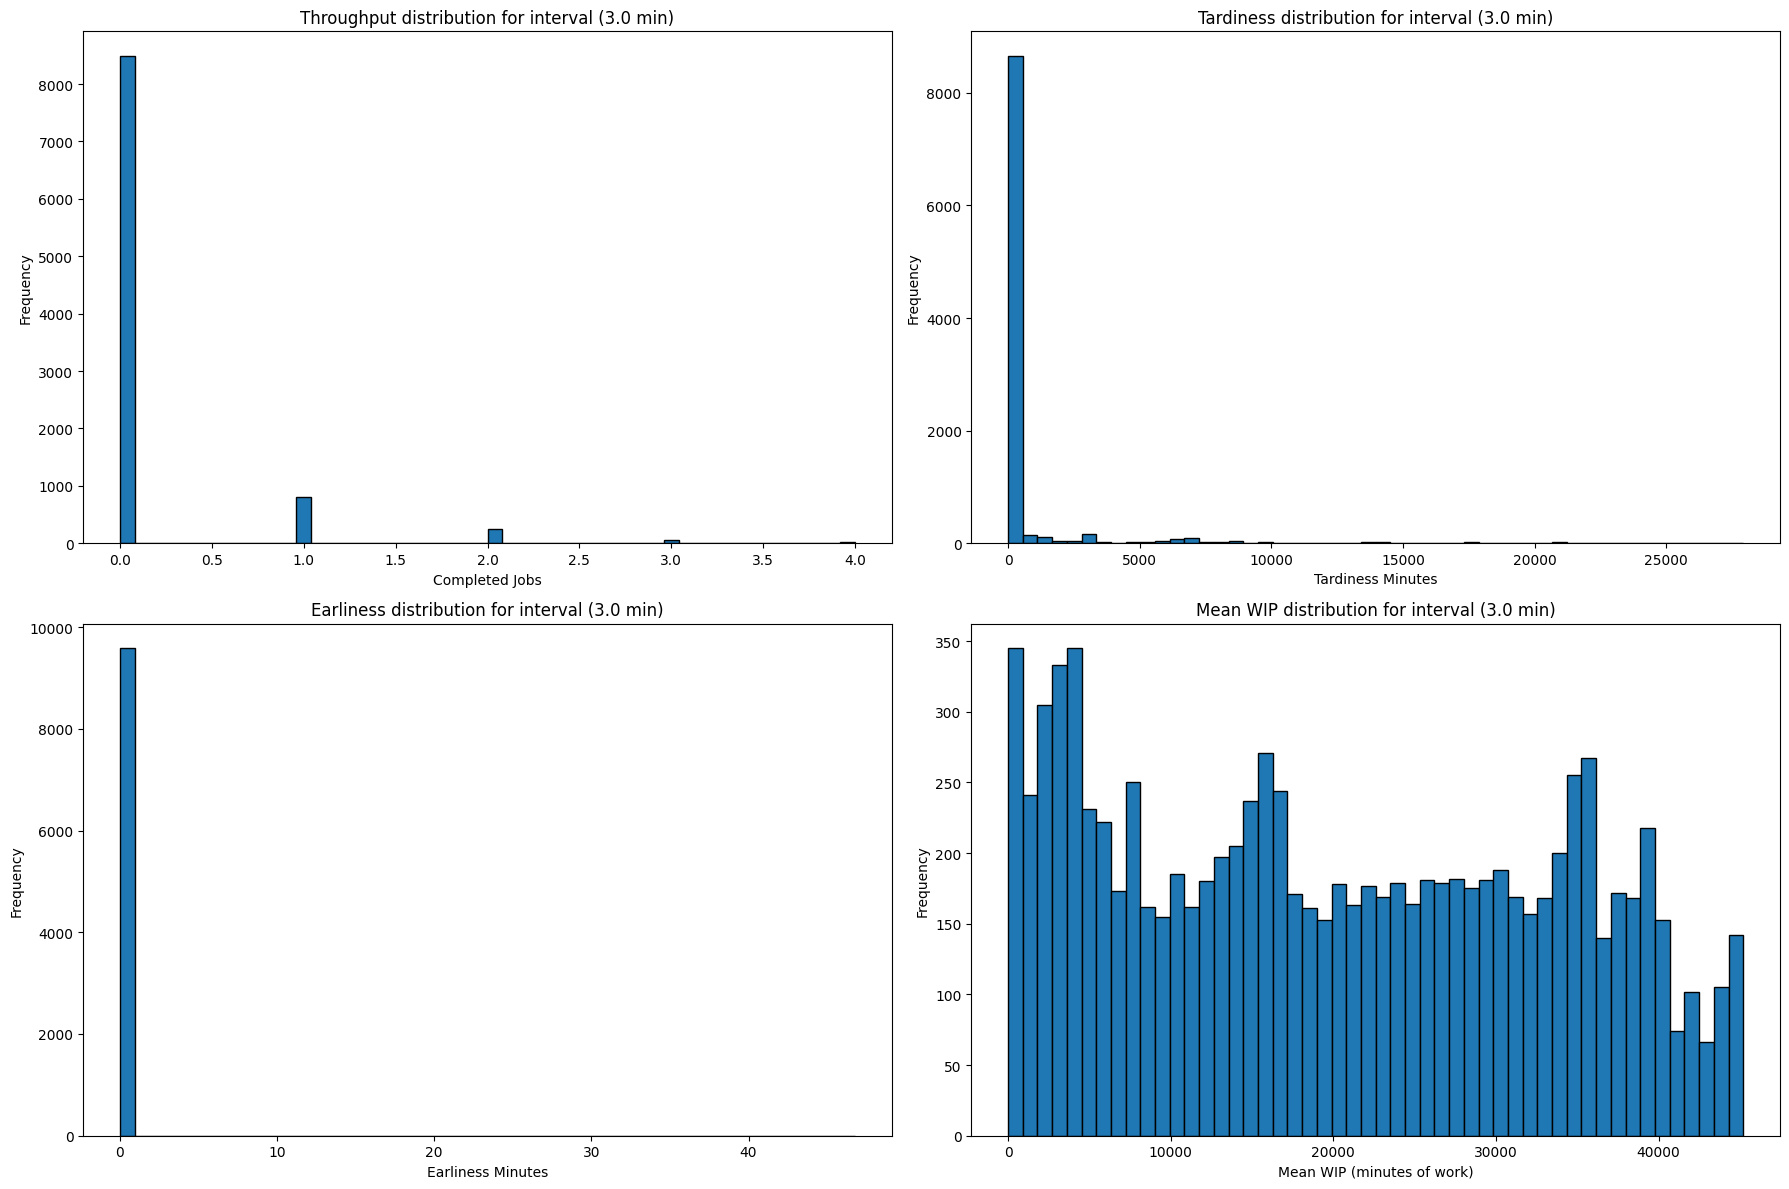

Obs - Job Top Proc Time: Min=0.36, Max=26.22
Obs - Job Top Urgency: Min=-8804.00, Max=-8.44
Obs - WIP Work Content (raw): Min=269.33, Max=44484.90


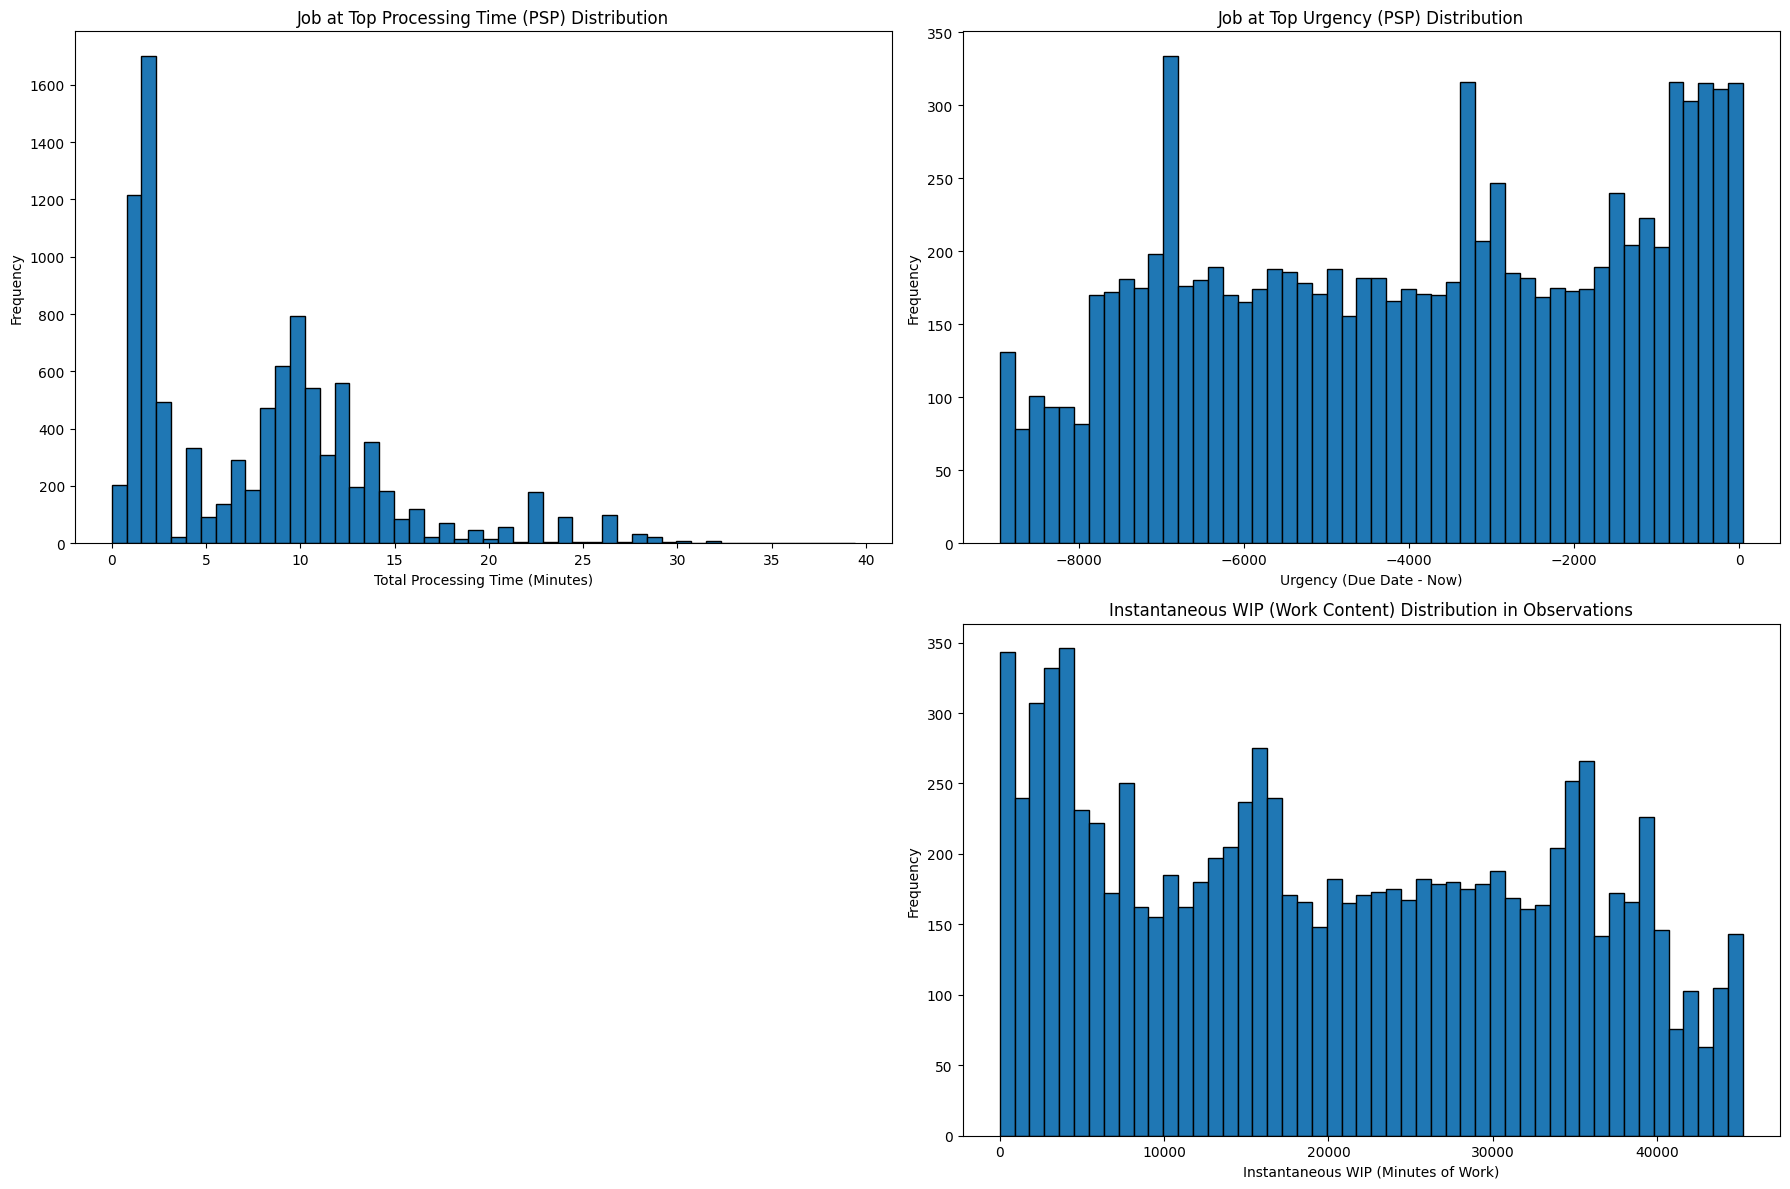

Obs - Machine Workloads (flattened): Min=44.88, Max=7932.25


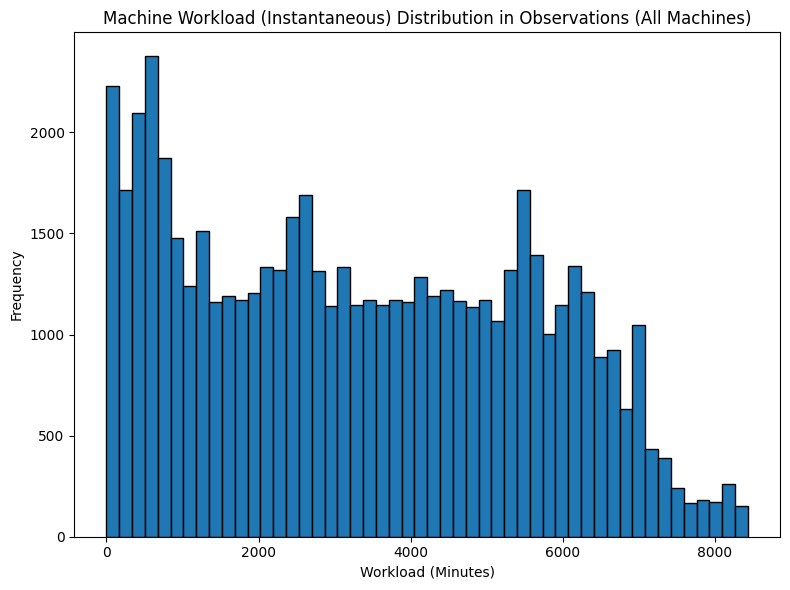


--- Summary of Calibrated Values to Insert into SystemEnv.py (for RL training) ---
# --- REWARD SCALING PARAMETERS ---
MIN_THROUGHPUT_INTERVAL = 0.00
MAX_THROUGHPUT_INTERVAL = 2.00
MIN_TARDINESS_INTERVAL = 0.00
MAX_TARDINESS_INTERVAL = 9754.16
MIN_EARLINESS_INTERVAL = 0.00
MAX_EARLINESS_INTERVAL = 0.00
MIN_WIP_WORK_CONTENT_INTERVAL = 267.68
MAX_WIP_WORK_CONTENT_INTERVAL = 44485.55

# --- OBSERVATION SPACE BOUNDS ---
low_bounds = np.array([
    0.36, # job_top_proc_time
    -8804.00, # job_top_urgency
    269.33, # raw_wip
    44.88, # machine_workload WC1
    44.88, # machine_workload WC2
    44.88, # machine_workload WC3
    44.88, # machine_workload WC4
    44.88, # machine_workload WC5
    44.88, # machine_workload WC6
], dtype=np.float32)

high_bounds = np.array([
    26.22, # job_top_proc_time
    -8.44, # job_top_urgency
    44484.90, # raw_wip
    7932.25, # machine_workload WC1
    7932.25, # machine_workload WC2
    7932.25, # machine_workload WC3
    7932.25, # machine_workl

In [22]:
calib_env = vec_env.envs[0].env

def get_min_max_percentile(data: list[float], low_p: float=1, high_p: float=99, clip_min_to_zero: bool = True):
    if not data:
        print(f"Given list is empty.")
        return 0.0, 1.0

    data_np = np.array(data)
    data_np = data_np[np.isfinite(data_np)]
    if data_np.size == 0:
        print(f"Attention: no more values are left after filtering the infinite values")
        return 0.0, 1.0

    min_val = np.percentile(data_np, low_p)
    max_val = np.percentile(data_np, high_p)
    if clip_min_to_zero:
        return float(max(0.0, min_val)), float(max_val)
    return float(min_val), float(max_val)


plt.figure(figsize=(18, 12))

plt.subplot(2, 2, 1)
if calib_env.calibration_throughput_intervals:
    plt.hist(calib_env.calibration_throughput_intervals, bins=50, edgecolor='black')
    min_th, max_th = get_min_max_percentile(calib_env.calibration_throughput_intervals)
    plt.title(f'Throughput distribution for interval ({THROW_AWAY_AGENT_DECISION_INTERVAL} min)')
    plt.xlabel('Completed Jobs')
    plt.ylabel('Frequency')
    print(f"Reward - Throughput Interval: Min={min_th:.2f}, Max={max_th:.2f}")
else:
    print("No throughput data left")
    min_th, max_th = 0.0, 1.0

plt.subplot(2, 2, 2)
if calib_env.calibration_tardiness_intervals:
    plt.hist(calib_env.calibration_tardiness_intervals, bins=50, edgecolor='black')
    min_tardiness, max_tardiness = get_min_max_percentile(calib_env.calibration_tardiness_intervals)
    plt.title(f'Tardiness distribution for interval ({THROW_AWAY_AGENT_DECISION_INTERVAL} min)')
    plt.xlabel('Tardiness Minutes')
    plt.ylabel('Frequency')
    print(f"Reward - Tardiness Interval: Min={min_tardiness:.2f}, Max={max_tardiness:.2f}")
else:
    print("No tardiness data left")
    min_tardiness, max_tardiness = 0.0, 1.0

plt.subplot(2, 2, 3)
if calib_env.calibration_earliness_intervals:
    plt.hist(calib_env.calibration_earliness_intervals, bins=50, edgecolor='black')
    min_earliness, max_earliness = get_min_max_percentile(calib_env.calibration_earliness_intervals)
    plt.title(f'Earliness distribution for interval ({THROW_AWAY_AGENT_DECISION_INTERVAL} min)')
    plt.xlabel('Earliness Minutes')
    plt.ylabel('Frequency')
    print(f"Reward - Earliness Interval: Min={min_earliness:.2f}, Max={max_earliness:.2f}")
else:
    print("No earliness data left")
    min_earliness, max_earliness = 0.0, 1.0


plt.subplot(2, 2, 4)
if calib_env.calibration_avg_wip_intervals:
    plt.hist(calib_env.calibration_avg_wip_intervals, bins=50, edgecolor='black')
    min_wip_wc_reward, max_wip_wc_reward = get_min_max_percentile(calib_env.calibration_avg_wip_intervals)
    plt.title(f'Mean WIP distribution for interval ({THROW_AWAY_AGENT_DECISION_INTERVAL} min)')
    plt.xlabel('Mean WIP (minutes of work)')
    plt.ylabel('Frequency')
    print(f"Reward - WIP Interval: Min={min_wip_wc_reward:.2f}, Max={max_wip_wc_reward:.2f}")
else:
    print("No WIP data left")
    min_wip_wc_reward, max_wip_wc_reward = 0.0, 1.0 # Default se non ci sono dati

plt.tight_layout()
plt.show()

plt.figure(figsize=(18, 12))

plt.subplot(2, 2, 1)
if calib_env.calibration_obs_job_top_proc_time:
    plt.hist(calib_env.calibration_obs_job_top_proc_time, bins=50, edgecolor='black')
    min_jtpt, max_jtpt = get_min_max_percentile(calib_env.calibration_obs_job_top_proc_time)
    plt.title('Job at Top Processing Time (PSP) Distribution')
    plt.xlabel('Total Processing Time (Minutes)')
    plt.ylabel('Frequency')
    print(f"Obs - Job Top Proc Time: Min={min_jtpt:.2f}, Max={max_jtpt:.2f}")
else:
    print("No job top processing time data collected for plotting.")
    min_jtpt, max_jtpt = 0.0, 1.0


plt.subplot(2, 2, 2)
if calib_env.calibration_obs_job_top_urgency:
    plt.hist(calib_env.calibration_obs_job_top_urgency, bins=50, edgecolor='black')
    min_jtu, max_jtu = get_min_max_percentile(calib_env.calibration_obs_job_top_urgency, clip_min_to_zero=False)
    plt.title('Job at Top Urgency (PSP) Distribution')
    plt.xlabel('Urgency (Due Date - Now)')
    plt.ylabel('Frequency')
    print(f"Obs - Job Top Urgency: Min={min_jtu:.2f}, Max={max_jtu:.2f}")
else:
    print("No job top urgency data collected for plotting.")
    min_jtu, max_jtu = -100.0, 100.0

plt.subplot(2, 2, 4)
if calib_env.calibration_obs_raw_wip:
    plt.hist(calib_env.calibration_obs_raw_wip, bins=50, edgecolor='black')
    min_wip_wc_obs, max_wip_wc_obs = get_min_max_percentile(calib_env.calibration_obs_raw_wip)
    plt.title('Instantaneous WIP (Work Content) Distribution in Observations')
    plt.xlabel('Instantaneous WIP (Minutes of Work)')
    plt.ylabel('Frequency')
    print(f"Obs - WIP Work Content (raw): Min={min_wip_wc_obs:.2f}, Max={max_wip_wc_obs:.2f}")
else:
    print("No raw WIP work content data collected for plotting.")
    min_wip_wc_obs, max_wip_wc_obs = 0.0, 1.0

plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 6))
if calib_env.calibration_obs_machine_workloads_flat:
    plt.hist(calib_env.calibration_obs_machine_workloads_flat, bins=50, edgecolor='black')
    min_mw, max_mw = get_min_max_percentile(calib_env.calibration_obs_machine_workloads_flat)
    plt.title('Machine Workload (Instantaneous) Distribution in Observations (All Machines)')
    plt.xlabel('Workload (Minutes)')
    plt.ylabel('Frequency')
    print(f"Obs - Machine Workloads (flattened): Min={min_mw:.2f}, Max={max_mw:.2f}")
else:
    print("No machine workload data collected for plotting.")
    min_mw, max_mw = 0.0, 1.0

plt.tight_layout()
plt.show()


print("\n--- Summary of Calibrated Values to Insert into SystemEnv.py (for RL training) ---")
print("# --- REWARD SCALING PARAMETERS ---")
print(f"MIN_THROUGHPUT_INTERVAL = {min_th:.2f}")
print(f"MAX_THROUGHPUT_INTERVAL = {max_th:.2f}")
print(f"MIN_TARDINESS_INTERVAL = {min_tardiness:.2f}")
print(f"MAX_TARDINESS_INTERVAL = {max_tardiness:.2f}")
print(f"MIN_EARLINESS_INTERVAL = {min_earliness:.2f}")
print(f"MAX_EARLINESS_INTERVAL = {max_earliness:.2f}")
print(f"MIN_WIP_WORK_CONTENT_INTERVAL = {min_wip_wc_reward:.2f}")
print(f"MAX_WIP_WORK_CONTENT_INTERVAL = {max_wip_wc_reward:.2f}")

print("\n# --- OBSERVATION SPACE BOUNDS ---")
print("low_bounds = np.array([")
print(f"    {min_jtpt:.2f}, # job_top_proc_time")
print(f"    {min_jtu:.2f}, # job_top_urgency")
print(f"    {min_wip_wc_obs:.2f}, # raw_wip")
for i in range(6):
    print(f"    {min_mw:.2f}, # machine_workload WC{i+1}")
print("], dtype=np.float32)")

print("\nhigh_bounds = np.array([")
print(f"    {max_jtpt:.2f}, # job_top_proc_time")
print(f"    {max_jtu:.2f}, # job_top_urgency")
print(f"    {max_wip_wc_obs:.2f}, # raw_wip")
for i in range(6):
    print(f"    {max_mw:.2f}, # machine_workload WC{i+1}")
print("], dtype=np.float32)")


In [6]:
def make_env():
    return SystemEnv(
        inter_arrival_time_distribution=lambda: random.expovariate(lambd=0.65),
        processing_time_per_family_distribution=[
            lambda: random.gammavariate(2,2),
            lambda: random.gammavariate(4,0.5),
            lambda: random.gammavariate(6,1/6)
        ],
        families_distribution=lambda: random.random(),
        routing_distribution={
            1: [lambda: random.random(), lambda: random.random(), lambda: random.random(),lambda: random.random(),lambda: random.random(),lambda: random.random()],
            2: [lambda: random.random(), lambda: random.random(), lambda: random.random(),lambda: random.random(),lambda: random.random(),lambda: random.random()],
            3: [lambda: random.random(), lambda: random.random(), lambda: random.random(),lambda: random.random(),lambda: random.random(),lambda: random.random()]
        },
        routing_prob={
            1: [1,1,0,1,1,1],
            2: [0.8, 0.8, 1, 0.8, 0.8, 0.75],
            3: [0,0,1,0,0,0.75]
        },
        due_dates_distribution=lambda: random.uniform(30,50),
        reward_weights={
            'throughput': 1.0,
            'wip_penalty': -1,
            'earliness_penalty': -1,
            'tardiness_penalty': -1
        }
    )

num_envs = 4
seed = 42

vec_env = make_vec_env(make_env, n_envs=num_envs, seed=seed)
vec_env = VecNormalize(
    vec_env,
    norm_obs=True,
    norm_reward=True,
    clip_obs=10,
    clip_reward=10,
    gamma=0.99
)

model = DQN(
    "MlpPolicy",
    vec_env,
    verbose=1,
    learning_rate=1e-4,
    buffer_size=50000,
    learning_starts=1000,
    batch_size=32,
    tau=1.0,
    gamma=0.99,
    train_freq=(1, "step"),
    gradient_steps=1,
    exploration_fraction=0.1,
    exploration_initial_eps=1.0,
    exploration_final_eps=0.05,
    target_update_interval=1000,
    seed=seed
)

print("Starting DQN training...")
total_timesteps = 1000000
model.learn(total_timesteps=total_timesteps, log_interval=10)
print("DQN training finished")

model.save("production_system_agent_dqn_final")
vec_env.save("vec_normalize_stats_dqn_final.pkl")

Using cpu device
Starting DQN training...


KeyboardInterrupt: 

In [ ]:
print("\nStarting evaluation phase...")

eval_env = make_vec_env(make_env, n_envs=1, seed=seed + 1)

eval_env = VecNormalize.load("vec_normalize_stats_dqn_final.pkl", eval_env)

eval_env.training = False
eval_env.norm_reward = False

model = DQN.load("production_system_agent_dqn_final", env=eval_env)

num_eval_episodes = 10
episode_rewards = []
episode_tardiness = []
episode_throughput = []
episode_avg_wip = []

episode_hourly_throughput = []
episode_hourly_tardiness = []
episode_hourly_wip = []

for episode in range(num_eval_episodes):
    obs = eval_env.reset()
    print(f"Type of reset_result: {type(obs)}")
    print(f"Value of reset_result: {obs}")

    done = False
    total_reward = 0
    while not done:
        action, _states = model.predict(obs, deterministic=True)
        obs, reward, done_status_array, info = eval_env.step(action)
        print(obs, reward, done_status_array, info)
        total_reward += reward[0]
        if done_status_array[0]:
            episode_rewards.append(total_reward)
            episode_tardiness.append(info[0]["total_tardiness_episode"])
            episode_throughput.append(info[0]["jobs_completed_episode"])
            if "average_wip_for_episode" in info[0]:
                episode_avg_wip.append(info[0]["average_wip_for_episode"])
            else:
                print("Warning: 'average_wip_for_episode' not found in info dict for this episode.")

            current_simulation_time_minutes = info[0].get("total_simulation_time_minutes", 60 * 24 * 7)
            episode_duration_hours = current_simulation_time_minutes / 60.0
            if episode_duration_hours > 0:
                hourly_throughput = info[0]["jobs_completed_episode"] / episode_duration_hours
                episode_hourly_throughput.append(hourly_throughput)

                hourly_tardiness = info[0]["total_tardiness_episode"] / episode_duration_hours
                episode_hourly_tardiness.append(hourly_tardiness)

                episode_hourly_wip.append(info[0]["average_wip_for_episode"])
            else:
                episode_hourly_throughput.append(0.0)
                episode_hourly_tardiness.append(0.0)
                episode_hourly_wip.append(0.0)
            done = True

print(f"\nEvaluation on {num_eval_episodes} episodes:")
print(f"Average Reward per episode: {np.mean(episode_rewards):.2f}")
print(f"Average total tardiness per episode: {np.mean(episode_tardiness):.2f}")
print(f"Average Throughput per episode: {np.mean(episode_throughput):.2f}")
if episode_avg_wip:
    print(f"Average WIP per episode: {np.mean(episode_avg_wip):.2f}")

print("\n--- Hourly Metrics (Averages per Episode) ---")
if episode_hourly_throughput:
    print(f"Average Hourly Throughput: {np.mean(episode_hourly_throughput):.2f} jobs/hour")
else:
    print("No data for Average Hourly Throughput.")

if episode_hourly_tardiness:
    print(f"Average Hourly Tardiness: {np.mean(episode_hourly_tardiness):.2f} units/hour")
else:
    print("No data for Average Hourly Tardiness.")

if episode_hourly_wip:
    print(f"Average Hourly WIP (mean jobs in system): {np.mean(episode_hourly_wip):.2f} jobs")
else:
    print("No data for Average Hourly WIP.")

eval_env.close()
vec_env.close()
